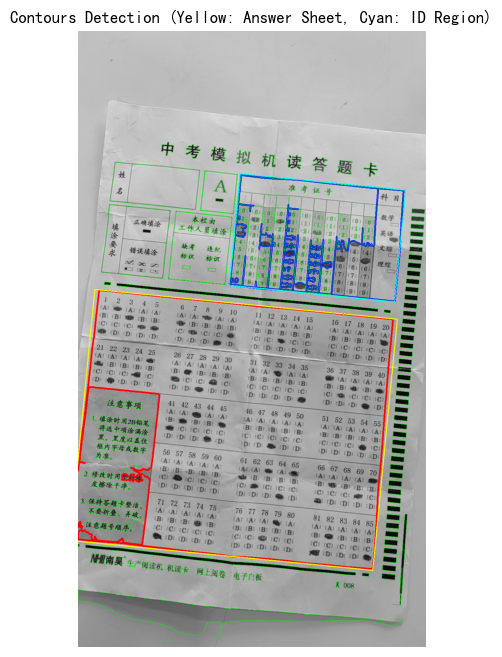

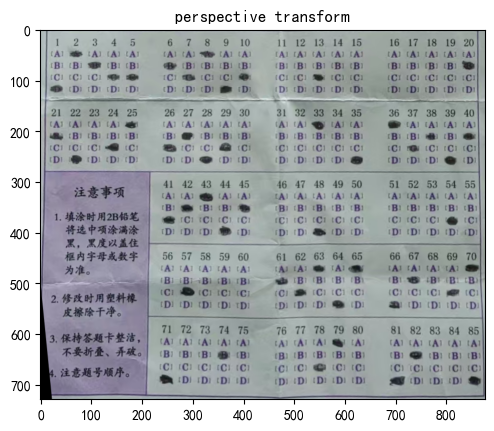

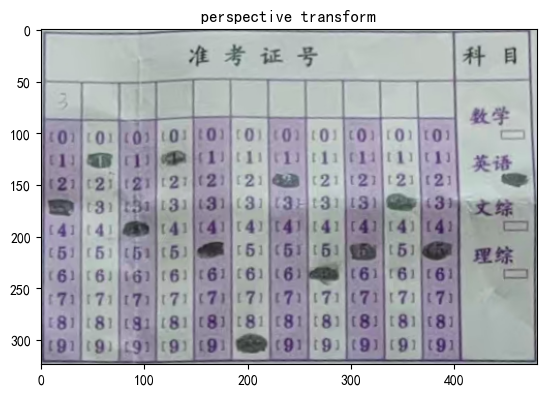

In [1]:
from find_region import process_answer_sheet
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from typing import Tuple, Optional, Dict, Any, List

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

image_path = 'images/test8.jpg'
ans_raw, _ = process_answer_sheet(image_path, show=True)

# 图像预处理

## 主程序

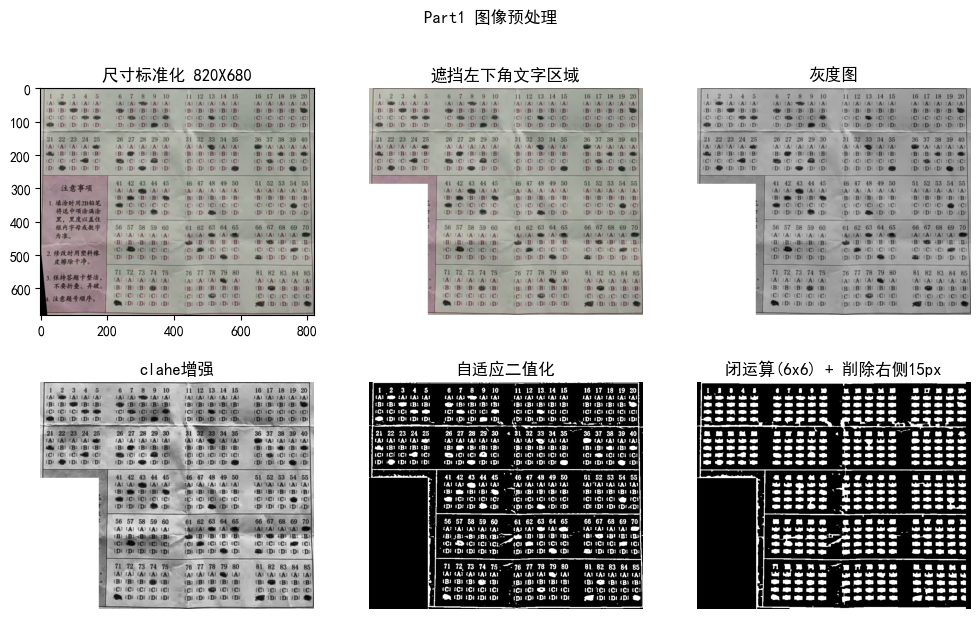

In [2]:
# Step1：尺寸标准化
target_size = (820, 680)
resized = cv2.resize(ans_raw, target_size)

# Step2: 遮盖左下角文字区域
masked = resized.copy()
mask_bottom = int(target_size[0] * 0.35)
mask_right = int(target_size[1] * 0.26)
masked[mask_bottom:, :mask_right] = 255

# Step3: 转灰度图
gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)

# Step4：clahe->增强图像对比度
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
gray_enhanced = clahe.apply(gray)

# Step5：自适应二值化
binary = cv2.adaptiveThreshold(gray_enhanced, 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY_INV, 
                                blockSize=31, 
                                C=15)

# Step6: 闭运算(将各点位轮廓闭合成方块)
right_strip_width = 15
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel) 
closed[:, -right_strip_width:] = 0  # 最右侧归零(为了最右侧连通区块的检测)

# 绘图
fig = plt.figure(figsize=(12, 7))
plt.suptitle('Part1 图像预处理')

ax1 = plt.subplot(2, 3, 1)
ax1.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
ax1.set_title(f'尺寸标准化 {target_size[0]}X{target_size[1]}')

ax2 = plt.subplot(2, 3, 2)
ax2.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB))
ax2.set_title('遮挡左下角文字区域')
ax2.set_axis_off()

ax3 = plt.subplot(2, 3, 3)
ax3.imshow(gray, cmap = 'gray')
ax3.set_title('灰度图')
ax3.set_axis_off()

ax4 = plt.subplot(2, 3, 4)
ax4.imshow(gray_enhanced, cmap = 'gray')
ax4.set_title('clahe增强')
ax4.set_axis_off()

ax5 = plt.subplot(2, 3, 5)
ax5.imshow(binary, cmap = 'gray')
ax5.set_title('自适应二值化')
ax5.set_axis_off()

ax6 = plt.subplot(2, 3, 6)
ax6.imshow(closed, cmap = 'gray')
ax6.set_title(f'闭运算(6x6) + 削除右侧{right_strip_width}px')
ax6.set_axis_off()




# 检测填涂点位

## 1、Kmeans聚类->确定区域分界线

In [3]:
def kmeans_clustering_regions(regions: List[Dict], resized: np.ndarray, n_rows = 5, n_cols = 4) -> Tuple[List[float], List[float]]:
    """KMeans聚类分割区域"""
    h, w = resized.shape[:2]
    
    if len(regions) >= max(n_rows, n_cols):
        print(f"进行KMeans聚类: {n_rows}行 × {n_cols}列")
        
        points = np.array([[r['centroid'][0], r['centroid'][1]] for r in regions])
        x_coords = points[:, 0].reshape(-1, 1)
        y_coords = points[:, 1].reshape(-1, 1)
        
        # 对Y坐标聚类
        kmeans_y = KMeans(n_clusters=min(n_rows, len(y_coords)), 
                         random_state=42, n_init=10)
        row_labels_raw = kmeans_y.fit_predict(y_coords)
        
        # 计算每个Y聚类的中心并排序
        row_centers = {}
        for label in np.unique(row_labels_raw):
            row_centers[label] = y_coords[row_labels_raw == label].mean()
        
        sorted_row_labels = sorted(row_centers.items(), key=lambda x: x[1])
        row_mapping = {old_label: i for i, (old_label, _) in enumerate(sorted_row_labels)}
        
        # 对X坐标聚类
        kmeans_x = KMeans(n_clusters=min(n_cols, len(x_coords)), 
                         random_state=42, n_init=10)
        col_labels_raw = kmeans_x.fit_predict(x_coords)
        
        # 计算每个X聚类的中心并排序
        col_centers = {}
        for label in np.unique(col_labels_raw):
            col_centers[label] = x_coords[col_labels_raw == label].mean()
        
        sorted_col_labels = sorted(col_centers.items(), key=lambda x: x[1])
        col_mapping = {old_label: i for i, (old_label, _) in enumerate(sorted_col_labels)}
        
        # 为每个区域分配行列标签
        for i, region in enumerate(regions):
            region['row_raw'] = int(row_labels_raw[i])
            region['col_raw'] = int(col_labels_raw[i])
            region['row'] = row_mapping[region['row_raw']]
            region['col'] = col_mapping[region['col_raw']]
        
        # 计算网格边界
        row_bounds = {}
        col_bounds = {}
        
        for region in regions:
            row = region['row']
            col = region['col']
            cx, cy = region['centroid']
            
            if row not in row_bounds:
                row_bounds[row] = {'min_y': cy, 'max_y': cy}
            else:
                row_bounds[row]['min_y'] = min(row_bounds[row]['min_y'], cy)
                row_bounds[row]['max_y'] = max(row_bounds[row]['max_y'], cy)
                
            if col not in col_bounds:
                col_bounds[col] = {'min_x': cx, 'max_x': cx}
            else:
                col_bounds[col]['min_x'] = min(col_bounds[col]['min_x'], cx)
                col_bounds[col]['max_x'] = max(col_bounds[col]['max_x'], cx)
        
        # 计算行分界线
        horizontal_lines = []
        for r in range(n_rows - 1):
            if r in row_bounds and r+1 in row_bounds:
                y_bottom = row_bounds[r]['max_y']
                y_top = row_bounds[r+1]['min_y']
                boundary = (y_bottom + y_top) / 2
                horizontal_lines.append(boundary)
        
        # 计算列分界线
        vertical_lines = []
        for c in range(n_cols - 1):
            if c in col_bounds and c+1 in col_bounds:
                x_right = col_bounds[c]['max_x']
                x_left = col_bounds[c+1]['min_x']
                boundary = (x_right + x_left) / 2
                vertical_lines.append(boundary)
        
        # 添加图像边界
        all_horizontal = [0] + sorted(horizontal_lines) + [h]
        all_vertical = [0] + sorted(vertical_lines) + [w]
        
    else:
        print(f"连通域数量({len(regions)})不足，无法进行聚类")
        all_horizontal = [0, h]
        all_vertical = [0, w]
    
    return all_horizontal, all_vertical


## 2、 根据边界线划分区域

In [4]:
def crop_regions(resized: np.ndarray, regions: List[Dict], all_horizontal: List[float], all_vertical: List[float], 
                        border_expand=10, n_rows=5, n_cols=4, min_points_per_region=5,
                        target_aspect_ratio=1.5, aspect_ratio_threshold=1.0) -> List[Dict]:
    """
    区域裁剪函数
    """
    h, w = resized.shape[:2]
    
    # 计算扩展后的分界线
    expanded_horizontal = [max(0, all_horizontal[0] - border_expand) if i == 0 else
                          min(h, all_horizontal[-1] + border_expand) if i == len(all_horizontal) - 1 else
                          y for i, y in enumerate(all_horizontal)]
    
    expanded_vertical = [max(0, all_vertical[0] - border_expand) if i == 0 else
                        min(w, all_vertical[-1] + border_expand) if i == len(all_vertical) - 1 else
                        x for i, x in enumerate(all_vertical)]
    
    cropped_regions = []
    region_counter = 1
    
    for r in range(n_rows):
        for c in range(n_cols):
            y1, y2 = expanded_horizontal[r], expanded_horizontal[r + 1]
            x1, x2 = expanded_vertical[c], expanded_vertical[c + 1]
            
            # 收集区域内的点
            region_points = []
            for region in regions:
                cx = region.get('centroid', region.get('center', (0, 0)))[0]
                cy = region.get('centroid', region.get('center', (0, 0)))[1]
                
                if x1 <= cx <= x2 and y1 <= cy <= y2:
                    region_points.append({'cx': cx, 'cy': cy})
            
            if len(region_points) >= min_points_per_region:
                width = int(x2 - x1)
                height = int(y2 - y1)
                aspect_ratio = width / max(height, 1)
                
                # 宽高比调整
                adjusted = False
                if aspect_ratio < aspect_ratio_threshold and height > 0:
                    target_height = int(width / target_aspect_ratio)
                    
                    if 0 < target_height < height:
                        # 计算两种裁剪方式保留的点数
                        crop_top = sum(1 for p in region_points if y1 <= p['cy'] <= y1 + target_height)
                        crop_bottom = sum(1 for p in region_points if y2 - target_height <= p['cy'] <= y2)
                        
                        if crop_top >= crop_bottom:
                            y2 = y1 + target_height
                        else:
                            y1 = y2 - target_height
                        
                        height = int(y2 - y1)
                        aspect_ratio = width / height
                        adjusted = True
                
                # 裁剪
                cropped = resized[int(y1):int(y2), int(x1):int(x2)]
                
                cropped_regions.append({
                    'region_id': region_counter,
                    'row': r,
                    'col': c,
                    'x1': int(x1), 'y1': int(y1), 'x2': int(x2), 'y2': int(y2),
                    'width': width, 'height': height,
                    'aspect_ratio': aspect_ratio,
                    'point_count': len(region_points),
                    'adjusted': adjusted,
                    'cropped': cropped
                })
                region_counter += 1
    
    return cropped_regions

## 主程序

进行KMeans聚类: 5行 × 4列


Text(0.5, 1.0, '原图区域划分结果')

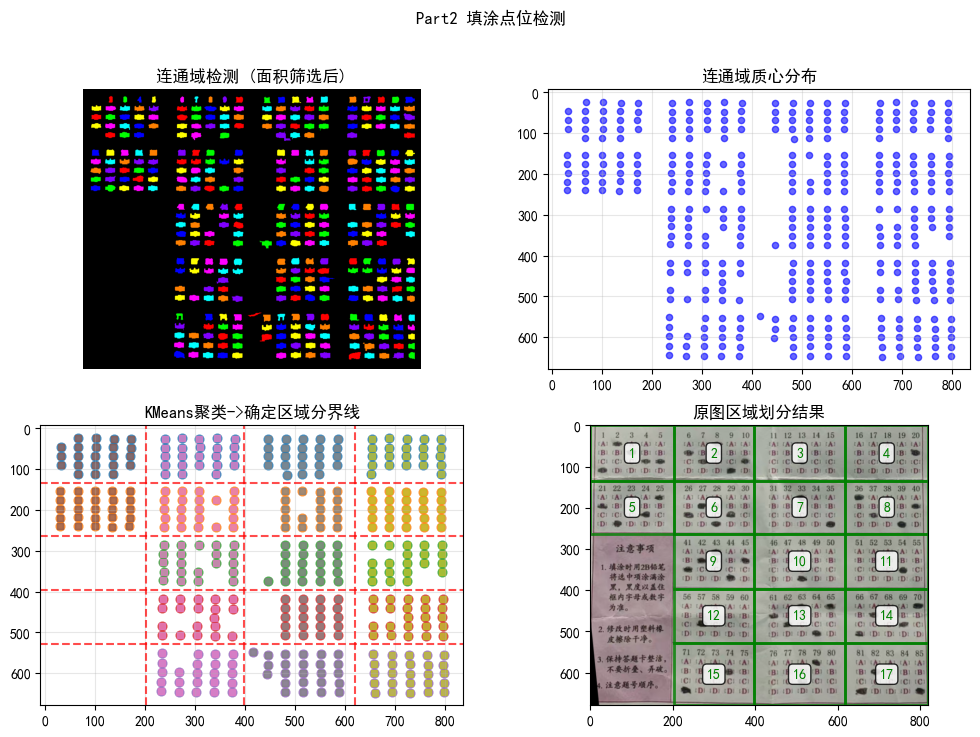

In [5]:
# Step6: 检测连通域 + 面积筛选
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed, connectivity=8)

regions = []
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if  80 <= area <= 400:
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w_rect = stats[i, cv2.CC_STAT_WIDTH]
        h_rect = stats[i, cv2.CC_STAT_HEIGHT]
        centroid_x, centroid_y = centroids[i]
        
        regions.append({
            'label': i,
            'area': area,
            'centroid': (centroid_x, centroid_y),
            'x': x,
            'y': y,
            'width': w_rect,
            'height': h_rect,
        })

# Step7: KMeans聚类(5行4列) -> 确定区域分界线(四条水平, 三条竖直)
h_lines, v_lines = kmeans_clustering_regions(regions, resized, n_rows=5, n_cols=4)

# Step8: 原图区域分割 
cropped_regions = crop_regions(resized, regions, h_lines, v_lines, border_expand = 10, n_rows = 5, n_cols = 4, min_points_per_region = 5)

# 绘图
fig = plt.figure(figsize=(12, 8))
plt.suptitle('Part2 填涂点位检测')

ax1 = plt.subplot(2, 2, 1)
label_colors = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
    (255, 0, 255), (0, 255, 255), (255, 128, 0), (128, 0, 255)
]

for idx, region in enumerate(regions):
    color_idx = idx % len(colors)
    color = colors[color_idx]
    label_colors[labels == region['label']] = color

ax1.imshow(label_colors)
ax1.set_title('连通域检测 (面积筛选后)')
ax1.set_axis_off()

ax2 = plt.subplot(2, 2, 2)
centroids_x = [r['centroid'][0] for r in regions]
centroids_y = [r['centroid'][1] for r in regions]
ax2.scatter(centroids_x, centroids_y, s=20, c='blue', alpha=0.6)
ax2.set_title('连通域质心分布')
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis()


ax3 = plt.subplot(2, 2, 3)
if regions and 'row' in regions[0] and 'col' in regions[0]:
    # 为不同行分配颜色
    unique_rows = sorted(set(r['row'] for r in regions))
    unique_cols = sorted(set(r['col'] for r in regions))
    
    # 绘制行聚类结果
    for row_idx, row in enumerate(unique_rows):
        row_points = [r for r in regions if r['row'] == row]
        x_vals = [r['centroid'][0] for r in row_points]
        y_vals = [r['centroid'][1] for r in row_points]
        ax3.scatter(x_vals, y_vals, s=40, 
                    label=f'行{row}', alpha=0.7)
    
    # 绘制列聚类结果
    for col_idx, col in enumerate(unique_cols):
        col_points = [r for r in regions if r['col'] == col]
        x_vals = [r['centroid'][0] for r in col_points]
        y_vals = [r['centroid'][1] for r in col_points]
        ax3.scatter(x_vals, y_vals, s=20, marker='s',
                    label=f'列{col}', alpha=0.7)
    
    # 绘制分割线
    for y in h_lines[1:-1]:
        ax3.axhline(y=y, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    for x in v_lines[1:-1]:
        ax3.axvline(x=x, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

ax3.set_title('KMeans聚类->确定区域分界线')
ax3.grid(True, alpha=0.3)
ax3.invert_yaxis()


ax4 = plt.subplot(2, 2, 4)
img_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
ax4.imshow(img_rgb)

# 绘制有效区域边界
for region in cropped_regions:
    x1, y1, x2, y2 = region['x1'], region['y1'], region['x2'], region['y2']
    color = 'green'
    
    # 绘制矩形框
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                        linewidth=2, edgecolor=color, 
                        facecolor='none', alpha=0.8)
    ax4.add_patch(rect)
    
    # 添加区域编号
    ax4.text(x1 + (x2-x1)/2, y1 + (y2-y1)/2, f"{region['region_id']}", 
            ha='center', va='center', fontsize=10, 
            color=color, weight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax4.set_title('原图区域划分结果')



# 检测点位填涂情况

## 1、单区域处理函数

In [ ]:
from recognize_id import independent_row_col_clustering, remove_duplicated_and_outliers, grid_linear_interpoltate

def process_single_region(region_img: np.ndarray, region_id: int, is_plot = True, show = False) -> Dict:
    """处理单个区域"""
    # Step1: 转换为灰度
    gray = cv2.cvtColor(region_img, cv2.COLOR_BGR2GRAY)
    
    # Step2: CLAHE增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_result = clahe.apply(gray)
    
    # Step3: 自适应二值化
    binary = cv2.adaptiveThreshold(clahe_result, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 31, 10)
    
    # Step4: 闭运算
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 2))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # Step5: 边缘置黑
    border_width = 10
    h, w = closed.shape
    if border_width > 0:
        closed[0:border_width, :] = 0
        closed[h-border_width:h, :] = 0
        closed[:, 0:border_width] = 0
        closed[:, w-border_width:w] = 0
    
    # Step6: 轮廓检测+尺寸过滤
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 过滤轮廓
    points = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, w_rect, h_rect = cv2.boundingRect(cnt)
        aspect_ratio = w_rect / h_rect if h_rect > 0 else 0
        
        if (20 <= area <= 300 and
            0.5 <= aspect_ratio <= 6.0):
               
            M = cv2.moments(cnt)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
            else:
                cx = x + w_rect // 2
                cy = y + h_rect // 2
            
            points.append({
                'x': x, 'y': y, 'w': w_rect, 'h': h_rect,
                'cx': cx, 'cy': cy, 
                'area': area,
            })    
    df_points = pd.DataFrame(points)

    # Step7: KMeans行列聚类
    df_clustered = independent_row_col_clustering(df_points.copy(), rows = 5, cols = 5)

    # Step8: 过滤离群点和重复点  
    df_cleaned, df_peripheral_removed, df_duplicates = remove_duplicated_and_outliers(df_clustered, interval_multiplier=1.5)
    
    # Step9: 插值填补缺失点
    df_grid, df_interpolated = grid_linear_interpoltate(df_cleaned, n_rows=5, n_cols=5)
     
    # Step10: 腐蚀二值化图
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))  
    eroded = cv2.erode(binary, kernel_erode)

    # Step11: 检测各点位填涂情况
    roi_w, roi_h = 24, 16
    fill_threshold = 0.4
    answer, df_result = detect_answers(region_id, df_grid, eroded, roi_size=(roi_w, roi_h), fill_threshold=fill_threshold)
    

    base_question_num = (region_id - 1) * 5 + 1

    fig = None
    if is_plot:
        fig = plt.figure(figsize=(15, 10))
        plt.suptitle(f"区域{region_id} 处理流程")

        ax1 = plt.subplot(3, 3, 1)
        plt.imshow(cv2.cvtColor(region_img, cv2.COLOR_BGR2RGB))
        ax1.set_title(f'原图')
        ax1.set_axis_off()

        ax2 = plt.subplot(3, 3, 2)
        plt.imshow(binary, cmap='gray')
        ax2.set_title(f'灰度->Clahe图像增强->自适应二值化')
        ax2.set_axis_off()

        ax3 = plt.subplot(3, 3, 3)
        plt.imshow(closed, cmap='gray')
        ax3.set_title(f'闭运算+边缘置黑')
        ax3.set_axis_off()   
        
        ax4 = plt.subplot(3, 3, 4)
        contour_img = cv2.cvtColor(region_img.copy(), cv2.COLOR_BGR2RGB) 
        for _, point in df_points.iterrows():
            cv2.rectangle(contour_img, (int(point['x']), int(point['y'])), 
                            (int(point['x']+point['w']), int(point['y']+point['h'])), 
                            (255, 0, 0), 2)
        ax4.imshow(contour_img)
        ax4.set_title(f'轮廓检测(尺寸筛选后)')
        ax4.set_axis_off()
        
        ax5 = plt.subplot(3, 3, 5)
        ax5.set_xlim(0, region_img.shape[1])
        ax5.set_ylim(region_img.shape[0], 0)
        ax5.set_aspect('equal')
        for idx, row in df_duplicates.iterrows():
            ax5.plot(row['cx'], row['cy'], 'o', 
                    color='orange', markersize=3, alpha=0.6, markerfacecolor='orange')
        for idx, row in df_peripheral_removed.iterrows():
            ax5.plot(row['cx'], row['cy'], 'x', 
                    color='gray', markersize=5, alpha=0.8, mew=1.5)
        for idx, row in df_cleaned.iterrows():
            ax5.plot(row['cx'], row['cy'], 'ro', markersize=3, alpha=0.8)
        ax5.set_title('KMeans聚类 + 去偏去重\n(红=保留, 橙=重复, 灰X=滤除)')
        ax5.grid(True, alpha=0.3)

        ax6 = plt.subplot(3, 3, 6)
        ax6.set_xlim(0, region_img.shape[1])
        ax6.set_ylim(region_img.shape[0], 0)
        ax6.set_aspect('equal')
        for idx, row in df_interpolated.iterrows():
            ax6.plot(row['cx'], row['cy'], '^', 
                    color='green', markersize=3, alpha=0.6, markerfacecolor='green')
        for idx, row in df_cleaned.iterrows():
            ax6.plot(row['cx'], row['cy'], 'ro', markersize=3, alpha=0.8)
        ax6.set_title('插值\n(红=保留, 绿=插值)')
        ax6.grid(True, alpha=0.3)

        # 图7: 腐蚀图上标注各点位ROI
        ax7 = plt.subplot(3, 3, 7)
        
        # 将二值图像转换为彩色
        if len(eroded.shape) == 2:
            # 灰度/二值图像转彩色
            eroded_color = cv2.cvtColor(eroded, cv2.COLOR_GRAY2BGR)
        else:
            eroded_color = eroded.copy()
        
        # 绘制每个点的ROI矩形框
        for idx, row in df_result.iterrows():
            x1 = int(row['cx'] - roi_w // 2)
            y1 = int(row['cy'] - roi_h // 2)
            x2 = int(row['cx'] + roi_w // 2)
            y2 = int(row['cy'] + roi_h // 2)
            
            # 确保ROI在图像范围内
            h_img, w_img = eroded_color.shape[:2]
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w_img, x2), min(h_img, y2)
            
            if x2 > x1 and y2 > y1:
                # 绘制绿色矩形框
                cv2.rectangle(eroded_color, (x1, y1), (x2, y2), (0, 255, 0), 1)
        
        ax7.imshow(cv2.cvtColor(eroded_color, cv2.COLOR_BGR2RGB))
        ax7.set_title(f'腐蚀图+ROI检测框\n(ROI大小: {roi_w}×{roi_h})')
        ax7.set_axis_off()
        
        # 图8: 在原图上标注填涂结果
        ax8 = plt.subplot(3, 3, 8)
        
        # 显示原图
        region_rgb = cv2.cvtColor(region_img, cv2.COLOR_BGR2RGB)
        ax8.imshow(region_rgb)
        
        # 格式化答案显示
        answer_display = ' '.join([ans if ans != '/' else '/' for ans in answer])
        ax8.set_title(f'检测答案: {answer_display}')
        
        # 绘制每个点的填涂状态
        for idx, row in df_result.iterrows():
            row_id = int(row['row_id'])
            col_id = int(row['col_id'])
            
            x1 = int(row['cx'] - roi_w // 2)
            y1 = int(row['cy'] - roi_h // 2)
            x2 = int(row['cx'] + roi_w // 2)
            y2 = int(row['cy'] + roi_h // 2)
            
            # 确保在图像范围内
            h_img, w_img = region_img.shape[:2]
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w_img, x2), min(h_img, y2)
            
            if row_id == 0:
                # 题号行：橙色框
                rect = plt.Rectangle((x1, y1), roi_w, roi_h, 
                                    fill=False, edgecolor='orange', 
                                    linewidth=1.5, alpha=0.8)
                
                # 添加题号标注
                if 'question_num' in row and not pd.isna(row['question_num']):
                    question_num = int(row['question_num'])
                    ax8.text(row['cx'], y1 - 5, f'Q{question_num}', 
                            color='orange', fontsize=11, ha='center', va='bottom', 
                            fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", 
                                                        facecolor='white', alpha=0.7))
            elif 1 <= row_id <= 4:
                # 选项行：根据填涂状态选择颜色
                if row['is_filled']:
                    color = 'green'
                    fill_alpha = 0.8
                    fill_face = False
                else:
                    color = 'red'
                    fill_alpha = 0.8
                    fill_face = False
                
                rect = plt.Rectangle((x1, y1), roi_w, roi_h, 
                                    fill=fill_face, edgecolor=color, 
                                    facecolor=color if fill_face else 'none',
                                    linewidth=2, alpha=fill_alpha)
            
            ax8.add_patch(rect)
        
        ax8.set_axis_off()
        
        # 图9: 5×5填涂比例热力图
        ax9 = plt.subplot(3, 3, 9)
        
        # 创建5×5填涂比例矩阵
        fill_matrix = np.zeros((5, 5))
        for idx, row in df_result.iterrows():
            row_id = int(row['row_id'])
            col_id = int(row['col_id'])
            if 0 <= row_id < 5 and 0 <= col_id < 5:
                fill_matrix[row_id, col_id] = row['fill_ratio']
        
        # 绘制热力图
        im = ax9.imshow(fill_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)
        
        # 添加颜色条
        cbar = plt.colorbar(im, ax=ax9, fraction=0.046, pad=0.04)
        cbar.set_label('填涂比例', fontsize=9)
        
        # 设置坐标轴
        ax9.set_xticks(range(5))
        ax9.set_yticks(range(5))
        
        # 列标签：题号
        col_labels = []
        for col in range(5):
            question_num = base_question_num + col
            col_labels.append(str(question_num))
        
        # 行标签
        row_labels = ['题号', 'A', 'B', 'C', 'D']
        
        ax9.set_xticklabels(col_labels, fontsize=9)
        ax9.set_yticklabels(row_labels, fontsize=9)
        ax9.set_xlabel('题号', fontsize=10)
        ax9.set_ylabel('选项', fontsize=10)
        
        # 在每个单元格中添加数值
        for i in range(5):
            for j in range(5):
                value = fill_matrix[i, j]
                text_color = 'black'
                text = f'{value:.2f}'
                
                # 根据是否超过阈值调整字体粗细
                fontweight = 'bold' if value > fill_threshold else 'normal'
                
                ax9.text(j, i, text, 
                        ha='center', va='center', 
                        color=text_color, fontsize=8, fontweight=fontweight)
                
                # 如果超过阈值，加上黑框
                if value > fill_threshold:
                    rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, 
                                        fill=False, edgecolor='black', 
                                        linewidth=2, alpha=0.8)
                    ax9.add_patch(rect)
        
        # 添加网格线
        ax9.set_xticks(np.arange(-0.5, 4.5, 1), minor=True)
        ax9.set_yticks(np.arange(-0.5, 4.5, 1), minor=True)
        ax9.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)
        ax9.tick_params(which="minor", size=0)
        
        ax9.set_title(f'填涂比例热力图(阈值={fill_threshold})', fontsize=11)
    
        if show:
            plt.show()
        else:
            plt.close(fig)       
    
    return {
        'region_id': region_id,
        'answer': answer,
        'df_result': df_result,
        'base_question_num': base_question_num
    }, fig


def detect_answers(region_id: int, df_grid: pd.DataFrame, image: np.ndarray, 
                   roi_size: Tuple[int, int], fill_threshold: float) -> Tuple[List[str], pd.DataFrame]:
    """
    检测选择题填涂情况
    
    参数:
    - region_id: 区域ID (1-20)
    - df_grid: 网格点DataFrame (5×5网格)
    - image: 处理后的二值化图像
    - roi_size: ROI大小 (width, height)
    - fill_threshold: 填涂阈值
    
    返回:
    - tuple[答案列表, 包含详细信息的DataFrame]
    """
    df = df_grid.copy()
    if df.empty or len(df) != 25:  # 5×5网格应该有25个点
        print(f"警告: 区域{region_id}网格点数量异常 ({len(df)}个点)")
        return [], df
    
    # 计算基础题号 (region_id=1对应题号1-5, region_id=2对应6-10, 以此类推)
    base_question_num = (region_id - 1) * 5 + 1
    print(f"区域{region_id}: 对应题号 {base_question_num}~{base_question_num+4}")
    
    # 初始化填涂相关列
    df['fill_ratio'] = 0.0
    df['is_filled'] = False
    df['is_question_row'] = False
    df['question_num'] = 0
    df['option_char'] = ''
    df['option_name'] = ''
    df['is_valid_option'] = False
    
    # 获取ROI大小
    roi_w, roi_h = roi_size
    threshold = fill_threshold
    
    # 首先检测所有点的填涂情况
    for idx, row in df.iterrows():
        # 计算ROI边界
        x1 = int(row['cx'] - roi_w // 2)
        y1 = int(row['cy'] - roi_h // 2)
        x2 = int(row['cx'] + roi_w // 2)
        y2 = int(row['cy'] + roi_h // 2)
        
        # 确保ROI在图像范围内
        h, w = image.shape
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        
        if x2 > x1 and y2 > y1:
            roi = image[y1:y2, x1:x2]
            if roi.size > 0:
                # 计算白色像素占比
                total_pixels = roi.size
                white_pixels = cv2.countNonZero(roi)
                fill_ratio = white_pixels / total_pixels
                
                df.at[idx, 'fill_ratio'] = fill_ratio
                
                # 判断是否填涂
                is_filled = fill_ratio > threshold
                df.at[idx, 'is_filled'] = is_filled
    
    # 识别答案
    answers = _recognize_answers(df, region_id, base_question_num)
    
    return answers, df


def _recognize_answers(df: pd.DataFrame, region_id: int, base_question_num: int) -> List[str]:
    """
    从填涂结果识别选择题答案
    
    网格布局:
    行0: 题号行 (不考虑填涂)
    行1-4: 选项行 (A, B, C, D)
    列0-4: 对应5道题
    
    返回格式: ['AB', 'C', '/', '/', 'ABC']  # 5道题的答案
    """
    if 'row_id' not in df.columns or 'col_id' not in df.columns:
        return []
    
    # 答案选项映射
    row_to_option = {
        0: '',     # 题号行
        1: 'A',    # 第一选项行
        2: 'B',    # 第二选项行
        3: 'C',    # 第三选项行
        4: 'D'     # 第四选项行
    }
    
    # 初始化结果
    answers = []
    
    # 获取列数范围 (0-4对应5道题)
    cols = sorted(df['col_id'].unique())
    if len(cols) != 5:
        print(f"警告: 区域{region_id}列数异常 ({len(cols)}列)")
        cols = list(range(5))
    
    for col in cols:
        if col < 0 or col >= 5:
            continue
            
        # 当前题号
        question_num = base_question_num + col
        
        # 获取该列的所有点
        col_points = df[df['col_id'] == col]
        
        # 标记题号行
        for idx, row in col_points.iterrows():
            if row['row_id'] == 0:
                df.at[idx, 'is_question_row'] = True
                df.at[idx, 'question_num'] = question_num
                df.at[idx, 'option_name'] = f'题号{question_num}'
        
        # 获取选项行 (行1-4)
        option_points = col_points[col_points['row_id'].between(1, 4)]
        
        # 查找填涂的选项
        filled_options = []
        
        for idx, row in option_points.iterrows():
            row_id = int(row['row_id'])
            option_char = row_to_option.get(row_id, '')
            
            # 更新选项信息
            df.at[idx, 'is_valid_option'] = True
            df.at[idx, 'question_num'] = question_num
            df.at[idx, 'option_char'] = option_char
            df.at[idx, 'option_name'] = f'{question_num}{option_char}'
            
            # 如果填涂，添加到答案
            if row['is_filled'] and option_char:
                filled_options.append(option_char)
        
        # 排序选项 (A, B, C, D 顺序)
        filled_options.sort()
        
        if filled_options:
            # 有填涂，合并选项字符串
            answer_str = ''.join(filled_options)
        else:
            # 没有填涂
            answer_str = '/'
        
        answers.append(answer_str)
        
        # 打印调试信息
        if filled_options:
            print(f"  题{question_num}: 答案 {answer_str} (填涂比例: {[option_points[option_points['row_id']==i]['fill_ratio'].values[0] if len(option_points[option_points['row_id']==i])>0 else 0 for i in range(1,5)]})")
    
    return answers


2、所有区域处理函数

In [62]:
def process_all_regions(image, cropped_regions, region_plot=None, region_plot_show=False, show=True):
    """处理所有区域 
    
    参数:
    - image: 原始图像
    - region_plot: None(不绘制) | 'All'(所有区域绘制处理过程图) | [1, 5](指定区域绘制处理过程图)
    - cropped_regions: 裁剪的区域列表
    - region_plot_show: 是否显示中间处理图
    - show: 是否显示最终汇总图
    """
    region_results = []
    region_plots = {}  # 改为不同的变量名
    
    # 处理region_plot参数
    if region_plot is None:
        plot_mode = 'none'
    elif region_plot == 'All':
        plot_mode = 'all'
    else:
        plot_mode = 'optional'
        region_plot_list = region_plot if isinstance(region_plot, list) else []
    
    for i, region in enumerate(cropped_regions, 1):
        print(f"\n正在处理区域 {i}...")
        
        region_img = region['cropped'].copy()
        
        # 处理并获取结果
        if plot_mode == 'none':  # 不绘制
            is_plot = False
            result, fig = process_single_region(region_img, i, is_plot=is_plot, show=False)
        elif plot_mode == 'optional':  # 只绘制指定图像
            is_plot = (i in region_plot_list)
            result, fig = process_single_region(region_img, i, is_plot=is_plot, show=(region_plot_show and is_plot))
        else:  # 绘制所有图像
            is_plot = True
            result, fig = process_single_region(region_img, i, is_plot=is_plot, show=region_plot_show)
        
        if is_plot and fig is not None:
            region_plots[i] = fig
        region_results.append(result)
    
    # 统计信息
    total_questions = 0
    answered_questions = 0
    all_answers = {}
    
    # 遍历每个区域收集答案
    for region_idx, (region, result) in enumerate(zip(cropped_regions, region_results)):
        region_id = region['region_id']
        
        if 'answer' in result:
            answers = result['answer']
            base_num = result.get('base_question_num', (region_id-1)*5 + 1)
            
            for i, ans in enumerate(answers):
                question_num = base_num + i
                all_answers[question_num] = ans
                total_questions += 1
                if ans != '/':
                    answered_questions += 1
    
    # ==================== 第一张图：全局答题情况 ====================
    if show:
        fig1 = plt.figure(figsize=(18, 12))
        ax1 = plt.subplot(111)
        
        # 显示原始图像
        ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # 用于题号标注的列表，避免重叠
        question_texts = []
        
        # 遍历每个区域
        for region_idx, (region, result) in enumerate(zip(cropped_regions, region_results)):
            region_id = region['region_id']
            
            # 检查是否有df_result
            if 'df_result' in result and not result['df_result'].empty:
                df_result = result['df_result']
                
                # 绘制每个点的填涂状态
                for idx, row in df_result.iterrows():
                    if 'row_id' not in row or 'col_id' not in row:
                        continue
                        
                    row_id = int(row['row_id'])
                    col_id = int(row['col_id'])
                    
                    # 计算该点在原图中的坐标
                    point_cx = int(region['x1'] + row['cx'])
                    point_cy = int(region['y1'] + row['cy'])
                    
                    # 计算ROI边界
                    roi_w, roi_h = 24, 16
                    x1_rect = point_cx - roi_w // 2
                    y1_rect = point_cy - roi_h // 2
                    x2_rect = point_cx + roi_w // 2
                    y2_rect = point_cy + roi_h // 2
                    
                    # 确保在图像范围内
                    h_img, w_img = image.shape[:2]
                    x1_rect = max(0, x1_rect)
                    y1_rect = max(0, y1_rect)
                    x2_rect = min(w_img, x2_rect)
                    y2_rect = min(h_img, y2_rect)
                    
                    if row_id == 0:
                        # 题号行：显示题号
                        if 'question_num' in row and not pd.isna(row['question_num']):
                            question_num = int(row['question_num'])
                        
                            # 在题号框处标注题号
                            ax1.text(point_cx, y1_rect + roi_h - 4, f'{question_num}', 
                                    color='orange', fontsize=14, ha='center', va='bottom', 
                                    fontweight='bold', 
                                    bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9))
                            question_texts.append((point_cx, y1_rect + roi_h + 8, question_num))
                    
                    elif 1 <= row_id <= 4:
                        # 选项行：根据填涂状态选择颜色
                        if 'is_filled' in row and row['is_filled']:
                            color = '#00FF00'  # 填涂 - 亮绿色
                            linewidth = 2
                            alpha = 0.8
                        else:
                            color = '#FF0000'  # 未填涂 - 亮红色
                            linewidth = 1.5
                            alpha = 0.6
                        
                        # 绘制矩形框
                        if x2_rect > x1_rect and y2_rect > y1_rect:  # 确保矩形有效
                            rect = plt.Rectangle((x1_rect, y1_rect), 
                                                x2_rect-x1_rect, y2_rect-y1_rect, 
                                                fill=False, edgecolor=color, 
                                                linewidth=linewidth, alpha=alpha)
                            ax1.add_patch(rect)
        
        ax1.set_axis_off()
        ax1.set_title('答题卡全局填涂检测结果', fontsize=16, pad=20)
        
        # 添加图例
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='white', edgecolor='#00FF00', linewidth=2, label='已填涂'),
            Patch(facecolor='white', edgecolor='#FF0000', linewidth=1.5, label='未填涂'),
            Patch(facecolor='white', edgecolor='orange', linewidth=2, label='题号位置')
        ]
        ax1.legend(handles=legend_elements, loc='lower left', fontsize=10, 
                   bbox_to_anchor=(1.0, 1.0), framealpha=0.9)
        
        # 调整布局
        plt.tight_layout()
        plt.show()
    else:
        fig1 = None
    
    # ==================== 第二张图：答题情况表格 ====================
    if show:
        fig2 = plt.figure(figsize=(16, 6))
        ax2 = plt.subplot(111)
        ax2.axis('off')
        ax2.set_title('答题情况汇总表', fontsize=16, pad=50)
        
        # 创建85道题的答案数组
        all_answers_list = ['/'] * 85
        for q_num, ans in all_answers.items():
            if 1 <= q_num <= 85:
                all_answers_list[q_num-1] = ans
        
        # 创建5×17的表格布局
        table_rows = 5
        table_cols = 17
        
        # 创建题号矩阵 (5×17)
        question_numbers = np.arange(1, 86).reshape(table_rows, table_cols)
        
        # 创建答案矩阵 (5×17)
        answer_matrix = np.array(all_answers_list).reshape(table_rows, table_cols)
        
        # 创建表格数据
        table_data = []
        for row in range(table_rows):
            # 题号行
            question_row = [f"{question_numbers[row, col]:3d}" for col in range(table_cols)]
            table_data.append(question_row)
            # 答案行
            answer_row = [answer_matrix[row, col] for col in range(table_cols)]
            table_data.append(answer_row)
        
        # 创建表格
        table = ax2.table(cellText=table_data, 
                         loc='center', 
                         cellLoc='center',
                         colWidths=[0.06] * table_cols)
        
        # 设置表格样式
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 1.8)  # 调整行高
        
        # 设置单元格样式
        for i in range(len(table_data)):
            for j in range(table_cols):
                cell = table[(i, j)]
                if i % 2 == 0:  # 题号行
                    cell.set_text_props(weight='bold', color='navy')
                    cell.set_facecolor('#F0F8FF')  # 非常浅的蓝色背景
                    cell.set_height(0.12)
                else:  # 答案行
                    answer = table_data[i][j]
                    if answer != '/':
                        cell.set_text_props(weight='bold', color='darkgreen')
                        cell.set_facecolor('#F0FFF0')  # 非常浅的绿色背景
                    else:
                        cell.set_text_props(color='darkred')
                        cell.set_facecolor('#FFF0F0')  # 非常浅的红色背景
                    cell.set_height(0.12)
        
        # 调整布局 
        plt.tight_layout()
        plt.show()
    else:
        fig2 = None
        
    return all_answers, region_plots, fig1, fig2


正在处理区域 1...
区域1: 对应题号 1~5
  题1.0: 答案 D (填涂比例: [0.24739583333333334, 0.2838541666666667, 0.22916666666666666, 0.5182291666666666])
  题2.0: 答案 A (填涂比例: [0.4427083333333333, 0.2838541666666667, 0.23697916666666666, 0.24739583333333334])
  题3.0: 答案 B (填涂比例: [0.2604166666666667, 0.5989583333333334, 0.24739583333333334, 0.2864583333333333])
  题4.0: 答案 C (填涂比例: [0.2526041666666667, 0.2760416666666667, 0.453125, 0.2630208333333333])
  题5.0: 答案 C (填涂比例: [0.2265625, 0.3046875, 0.4661458333333333, 0.23958333333333334])


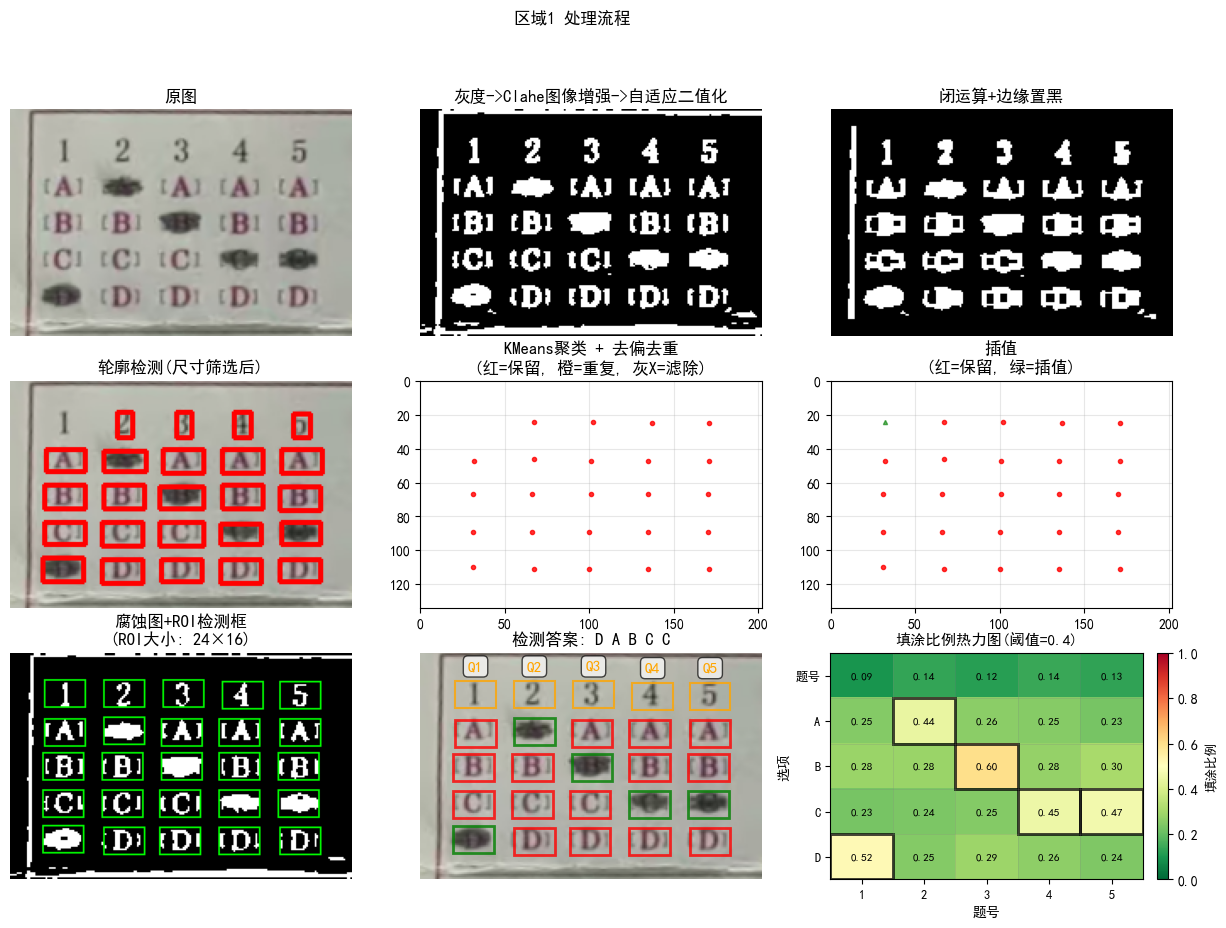


正在处理区域 2...
区域2: 对应题号 6~10
  题6.0: 答案 B (填涂比例: [0.234375, 0.5052083333333334, 0.23177083333333334, 0.24739583333333334])
  题7.0: 答案 C (填涂比例: [0.2604166666666667, 0.3203125, 0.4869791666666667, 0.2786458333333333])
  题8.0: 答案 A (填涂比例: [0.4817708333333333, 0.2864583333333333, 0.2421875, 0.2838541666666667])
  题9.0: 答案 D (填涂比例: [0.2578125, 0.2760416666666667, 0.22916666666666666, 0.5598958333333334])
  题10.0: 答案 C (填涂比例: [0.25, 0.2578125, 0.5, 0.2682291666666667])

正在处理区域 3...
区域3: 对应题号 11~15
  题13.0: 答案 C (填涂比例: [0.24739583333333334, 0.2786458333333333, 0.4583333333333333, 0.24739583333333334])

正在处理区域 4...
区域4: 对应题号 16~20
  题20.0: 答案 B (填涂比例: [0.23958333333333334, 0.5885416666666666, 0.17708333333333334, 0.23177083333333334])

正在处理区域 5...
区域5: 对应题号 21~25
  题21.0: 答案 B (填涂比例: [0.28125, 0.4947916666666667, 0.23697916666666666, 0.2421875])
  题22.0: 答案 D (填涂比例: [0.2838541666666667, 0.28125, 0.22135416666666666, 0.5729166666666666])
  题24.0: 答案 C (填涂比例: [0.2734375, 0.28125, 0.56510416666666

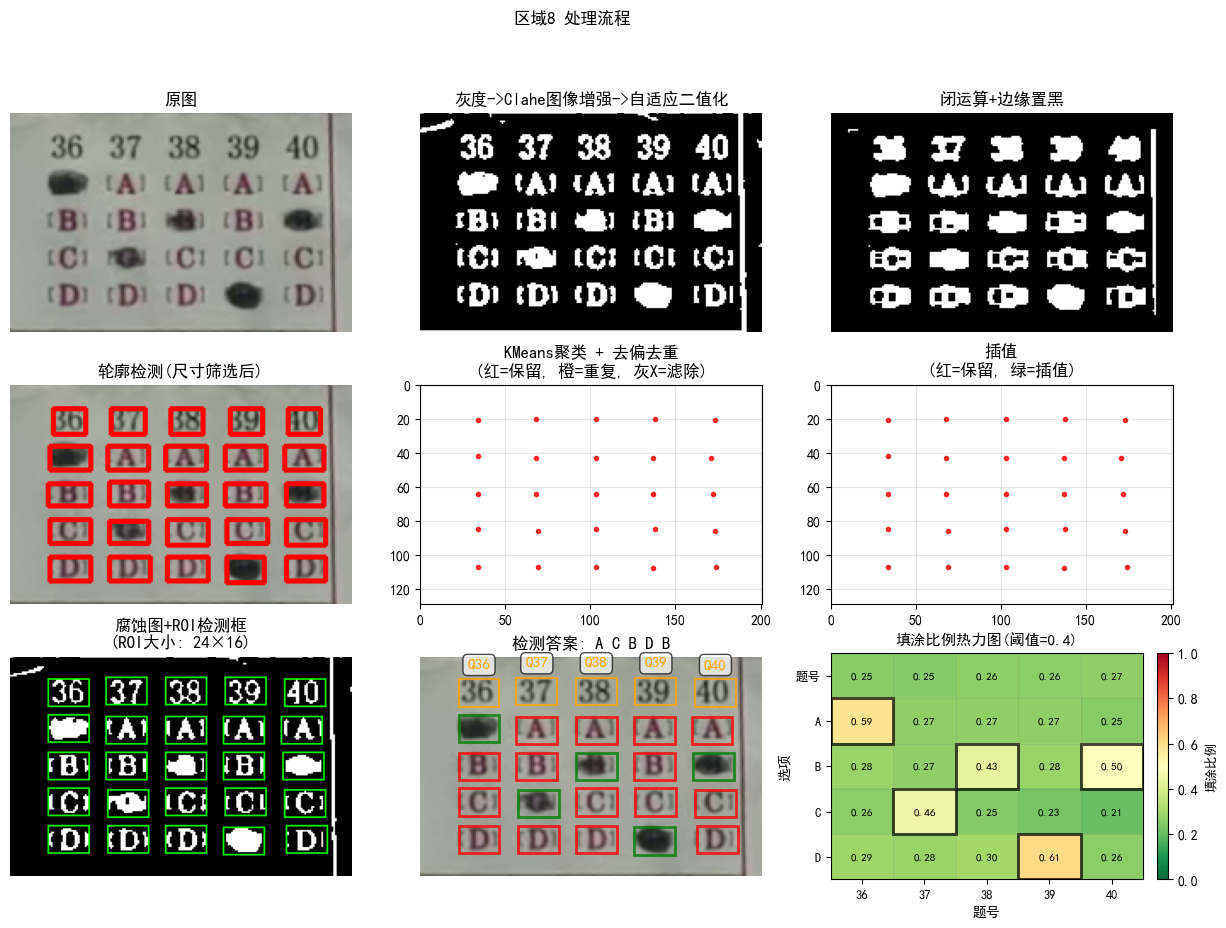


正在处理区域 9...
区域9: 对应题号 41~45
  题41.0: 答案 C (填涂比例: [0.25, 0.24479166666666666, 0.5625, 0.2708333333333333])
  题42.0: 答案 B (填涂比例: [0.2760416666666667, 0.5677083333333334, 0.2708333333333333, 0.25])
  题43.0: 答案 A (填涂比例: [0.6979166666666666, 0.2942708333333333, 0.2734375, 0.2864583333333333])
  题44.0: 答案 D (填涂比例: [0.265625, 0.3098958333333333, 0.24739583333333334, 0.6067708333333334])
  题45.0: 答案 B (填涂比例: [0.265625, 0.5729166666666666, 0.2552083333333333, 0.3151041666666667])

正在处理区域 10...
区域10: 对应题号 46~50
  题48.0: 答案 D (填涂比例: [0.24479166666666666, 0.3098958333333333, 0.2630208333333333, 0.5390625])

正在处理区域 11...
区域11: 对应题号 51~55
  题54.0: 答案 C (填涂比例: [0.2421875, 0.3255208333333333, 0.5729166666666666, 0.24479166666666666])

正在处理区域 12...
区域12: 对应题号 56~60
  题57.0: 答案 C (填涂比例: [0.2421875, 0.24739583333333334, 0.6510416666666666, 0.28125])

正在处理区域 13...
区域13: 对应题号 61~65
  题61.0: 答案 B (填涂比例: [0.296875, 0.5, 0.24739583333333334, 0.2864583333333333])
  题62.0: 答案 C (填涂比例: [0.25, 0.28125, 0.5546875

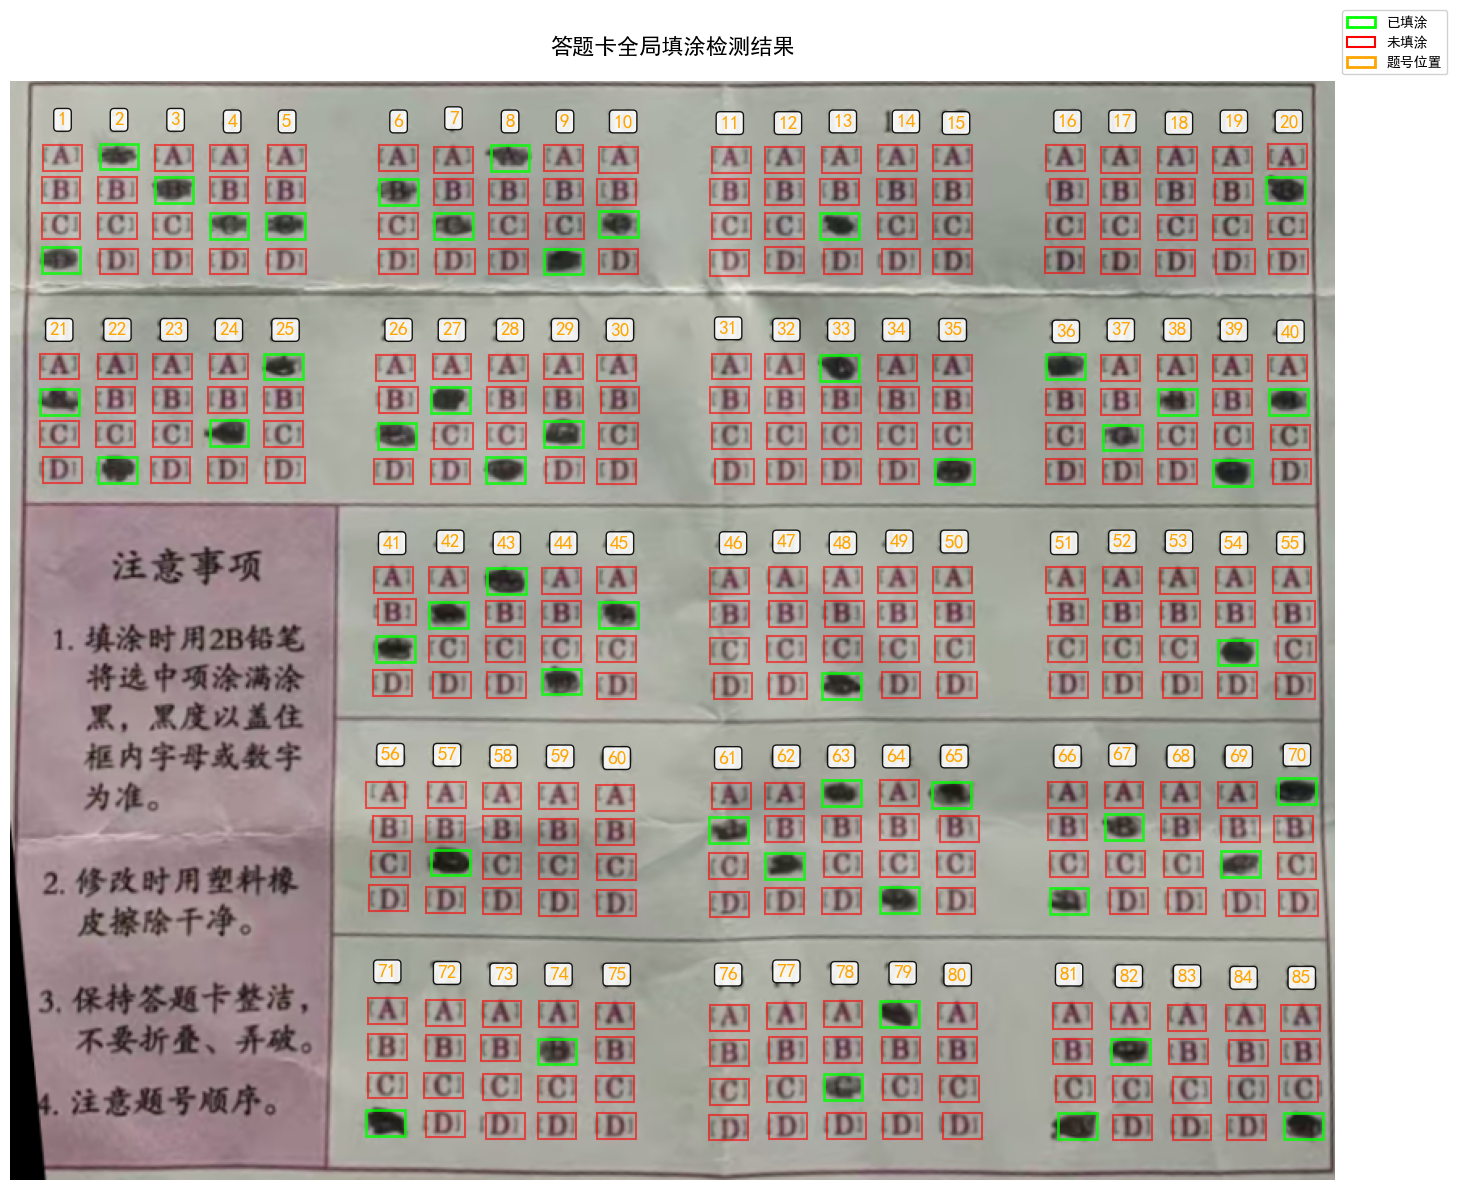

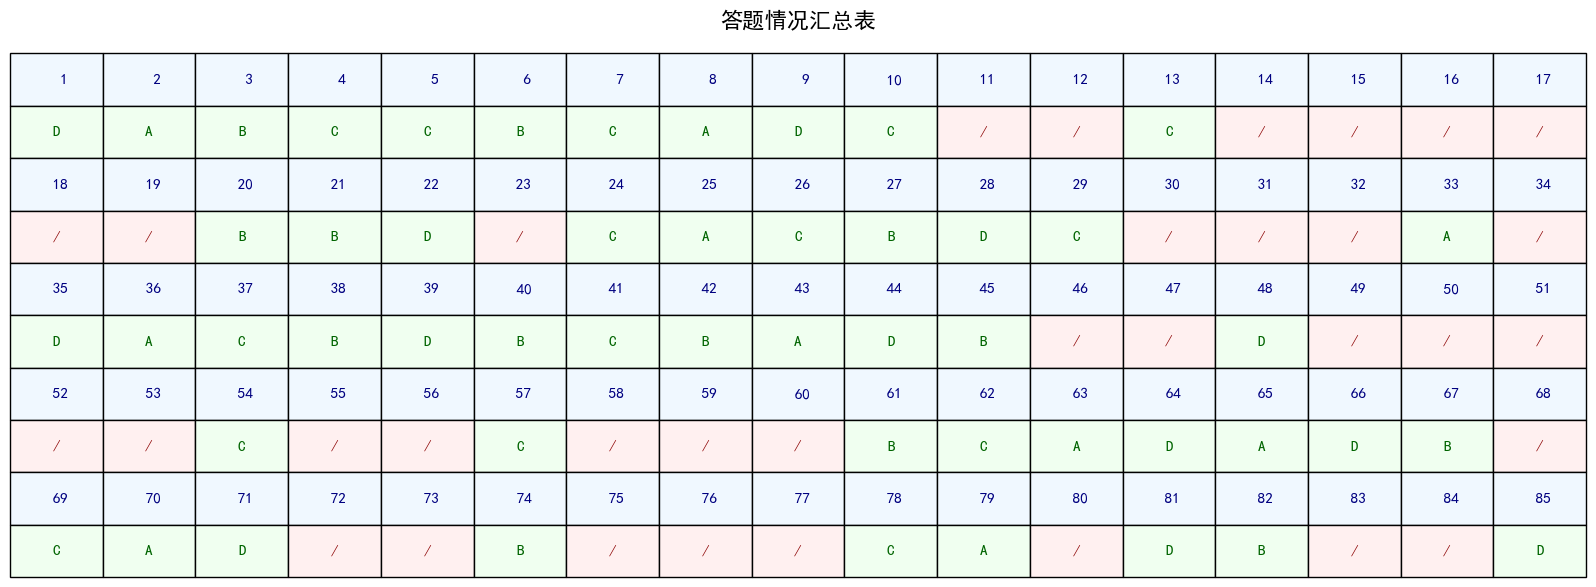

{}


In [65]:
all_answers, region_plots, fig1, fig2 = process_all_regions(resized, cropped_regions, region_plot = [1, 8], region_plot_show = True, show = True)
print(region_plots)